<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/FXPROBOT_Trained_17_pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 6.2 MB/s 
     |████████████████████████████████| 748 kB 62.1 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
pip install feedparser

     |████████████████████████████████| 81 kB 4.6 MB/s 
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=901c2566f9e37f61a7d77f860670c19f20d91f85b0d0ad16d003c5b5e02ffa1d
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36cebfdddfe059f50e019aa
Successfully built sgmllib3k


In [3]:
import requests
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import warnings
from termcolor import colored as cl
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
dropUnamed = True # if the dataset contains unamed column
nltk.downloader.download('vader_lexicon')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
from joblib import load
symbols = ["EURUSD", "USDJPY", "USDCHF", "USDCAD", "NZDUSD", "GBPUSD", "EURGBP", "EURCHF", "CHFJPY",  "AUDUSD", "AUDJPY"]
models = {}
for symbol in symbols:
  models[symbol] =  load('/content/drive/MyDrive/data/FX{symbol}.joblib'.format(symbol=symbol))
  print ('Model FXPROBOT-{symbol} Loaded'.format(symbol = symbol))

Model FXPROBOT-EURUSD Loaded
Model FXPROBOT-USDJPY Loaded
Model FXPROBOT-USDCHF Loaded
Model FXPROBOT-USDCAD Loaded
Model FXPROBOT-NZDUSD Loaded
Model FXPROBOT-GBPUSD Loaded
Model FXPROBOT-EURGBP Loaded
Model FXPROBOT-EURCHF Loaded
Model FXPROBOT-CHFJPY Loaded
Model FXPROBOT-AUDUSD Loaded
Model FXPROBOT-AUDJPY Loaded


In [5]:
# constants
period = 19
data_window = 1000
macd_slow = 38*8
macd_fast = 19*8
macd_smooth = 9*8
rsi_period = period
magic_ratio = 1.618


def get_macd(df, slow, fast, smooth):
    exp1_8 = df['Close'].ewm(span = fast, adjust = False).mean()
    exp2_8 = df['Close'].ewm(span = slow, adjust = False).mean()
    # 4Hour MACD
    df['macd8'] = pd.DataFrame(exp1_8 - exp2_8)
    df['signal8']  = pd.DataFrame(df['macd8'].ewm(span = smooth, adjust = False).mean())
    df['hist8'] = pd.DataFrame(df['macd8'] - df['signal8'])
    return df

def get_rsi(df, lookback):
    ret = df['Close'].diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(df['Close'].index)
    rsi_df = rsi_df.dropna()
    df['rsi'] = rsi_df[3:]
    return df


In [6]:
# filter features
feature_names = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'macd8', 'signal8',
       'hist8', 'rsi', 'max_price', 'min_price',
       'tsignal', 'atsignal', 'moment']
non_features = ['Date', 'tsignal', 'min_price', 'max_price', 'Open', 'High', 'Low', 'atsignal', 'moment']
for nf in non_features:
  feature_names.remove(nf)
print(feature_names)

['Close', 'Volume', 'macd8', 'signal8', 'hist8', 'rsi']


In [7]:
# Alternative data mining 
# get social sentiment from news feed
def getSentiment(news_list, symbol):
  filteredList = []
  for news in news_list:
    if symbol in news:
      filteredList.append(news)
  if filteredList:
    vader = SentimentIntensityAnalyzer()
    columns = ['headline']
    news_df = pd.DataFrame(filteredList, columns=columns)
    scores = news_df['headline'].apply(vader.polarity_scores).tolist()
    scores_df = pd.DataFrame(scores)
    news_df = news_df.join(scores_df, rsuffix='_right')
    plt.rcParams['figure.figsize'] = [10, 6]
    # get positive negative percentages
    total = news_df['pos'].mean() + news_df['neg'].mean()
    try:    
      pos = "{:.2f}".format(news_df['pos'].mean()*100/total)
      neg = "{:.2f}".format(news_df['neg'].mean()*100/total)
      # labels
      y = np.array([pos,neg]) 
      if y is None:
        y = np.array([0,0]) 
      return y
    except:
      return 

In [8]:
import feedparser
import dateutil.parser
news_list = []
urls = ['https://www.dailyfx.com/feeds/market-news',
        'https://analysis.hotforex.com/feed/',
        'https://www.fxstreet.com/rss',
        'https://www.forexlive.com/feed/',
        'https://www.investing.com/rss/forex.rss',
    ]
feeds = [feedparser.parse(url)['entries'] for url in urls]
for feed in feeds:
  for item in feed:
    if 'summary' in item:
      news_list.append ('{title}: {summary}'.format(title=item.title, summary=item.summary))
    else:
      # in case the stream doesnt contain summary
      news_list.append ('{title}'.format(title=item.title))
print('{n} News Feed Loaded'.format(n=len(news_list)))

95 News Feed Loaded


In [9]:
# predictions
def predict(symbol):
  data = urllib.request.urlopen(api_endpoint.format(symbol=symbol.upper(), key=api_key)).read()
  target[symbol] = pd.json_normalize(json.loads(data))
  target[symbol].columns = pd.Series(target[symbol].columns.str.capitalize())
  target[symbol].index = pd.to_datetime(target[symbol]['Date'])
  target[symbol] = target[symbol][target[symbol].index.dayofweek < 5]
  # compute indicators
  target[symbol] = get_macd(target[symbol], macd_slow, macd_fast, macd_smooth)
  target[symbol] = get_rsi(target[symbol], rsi_period)
  
  target[symbol]['Date'] = pd.to_datetime(target[symbol].index)
  target[symbol]['moment'] = target[symbol]['Date'].dt.month*10 + target[symbol]['Date'].dt.dayofweek
  target[symbol].drop(['Open', 'High', 'Low'], axis=1)
  target[symbol]['tsignal'] = '0'
  target[symbol]['atsignal'] = '0'
  target[symbol]['min_price'] = '0'
  target[symbol]['max_price'] = '0'
  target[symbol]['Volume'].replace(0, np.nan, inplace=True)
  target[symbol].replace([np.inf, -np.inf], np.nan, inplace=True)
  target[symbol].dropna(inplace=True)
  # Save Close prices
  close = target[symbol]["Close"]
  target[symbol].drop(non_features, axis=1, inplace=True)
  target[symbol]['predicted_signal'] = models[symbol].predict(target[symbol]) 
  print('SIGNALS FOR {symbol}'.format(symbol = symbol))
  # Restore Close prices
  target[symbol]["Close"] = close
  prediction_data = target[symbol]
  print(prediction_data.head())
  # Initialize the plot figure
  fig = plt.figure(figsize=(32,16))
  ## Add a subplot and label for y-axis
  ax1 = fig.add_subplot(111,ylabel=symbol)
  ax2 = fig.add_subplot(111,ylabel='Sentiment')
  ## Plot the closing price
  target[symbol]['Close'].plot(ax=ax1, color='g', lw=2.)
  # Plot buy signals
  ax1.plot(target[symbol].loc[target[symbol].predicted_signal == 1.0].index, 
          target[symbol].Close[target[symbol].predicted_signal == 1.0],
          '^', markersize=10, color='b')
  # Plot sell signals
  ax1.plot(target[symbol].loc[target[symbol].predicted_signal == -1.0].index, 
          target[symbol].Close[target[symbol].predicted_signal == -1.0],
          'v', markersize=10, color='r')
  # get the sentiment for each symbol (example: GBP/USD)
  sentiment = getSentiment(news_list, symbol[:3] + '/' + symbol[3:])
  if sentiment is None:
    sentiment = np.array([0, 0])
  mylabels = ["{pc}% Positive".format(pc=sentiment[0]), "{pc}% Negative".format(pc=sentiment[1])]
  mycolors = ["green", "red"]
  ax2.pie(sentiment, labels = mylabels, colors = mycolors, radius=0.3)
  ax2.legend(title = "{symbol} Sentiment Analysis".format(symbol=symbol))

SIGNALS FOR EURUSD
                       Close  Volume  ...        rsi  predicted_signal
Date                                  ...                             
2022-02-03 15:00:00  1.14331    2507  ...  27.554156                 0
2022-02-03 14:30:00  1.14329    2967  ...  27.136229                 0
2022-02-03 14:00:00  1.14386    2823  ...  49.966083                 0
2022-02-03 13:30:00  1.14425    2752  ...  59.198899                 0
2022-02-03 13:00:00  1.14287    3289  ...  35.044865                 0

[5 rows x 7 columns]
SIGNALS FOR USDJPY
                       Close  Volume  ...        rsi  predicted_signal
Date                                  ...                             
2022-02-03 15:00:00  114.919    1990  ...  80.935364                 0
2022-02-03 14:30:00  114.933    1892  ...  81.778507                 0
2022-02-03 14:00:00  114.915    1647  ...  77.148057                 0
2022-02-03 13:30:00  114.911    1654  ...  76.136833                 0
2022-02-03 13:00:

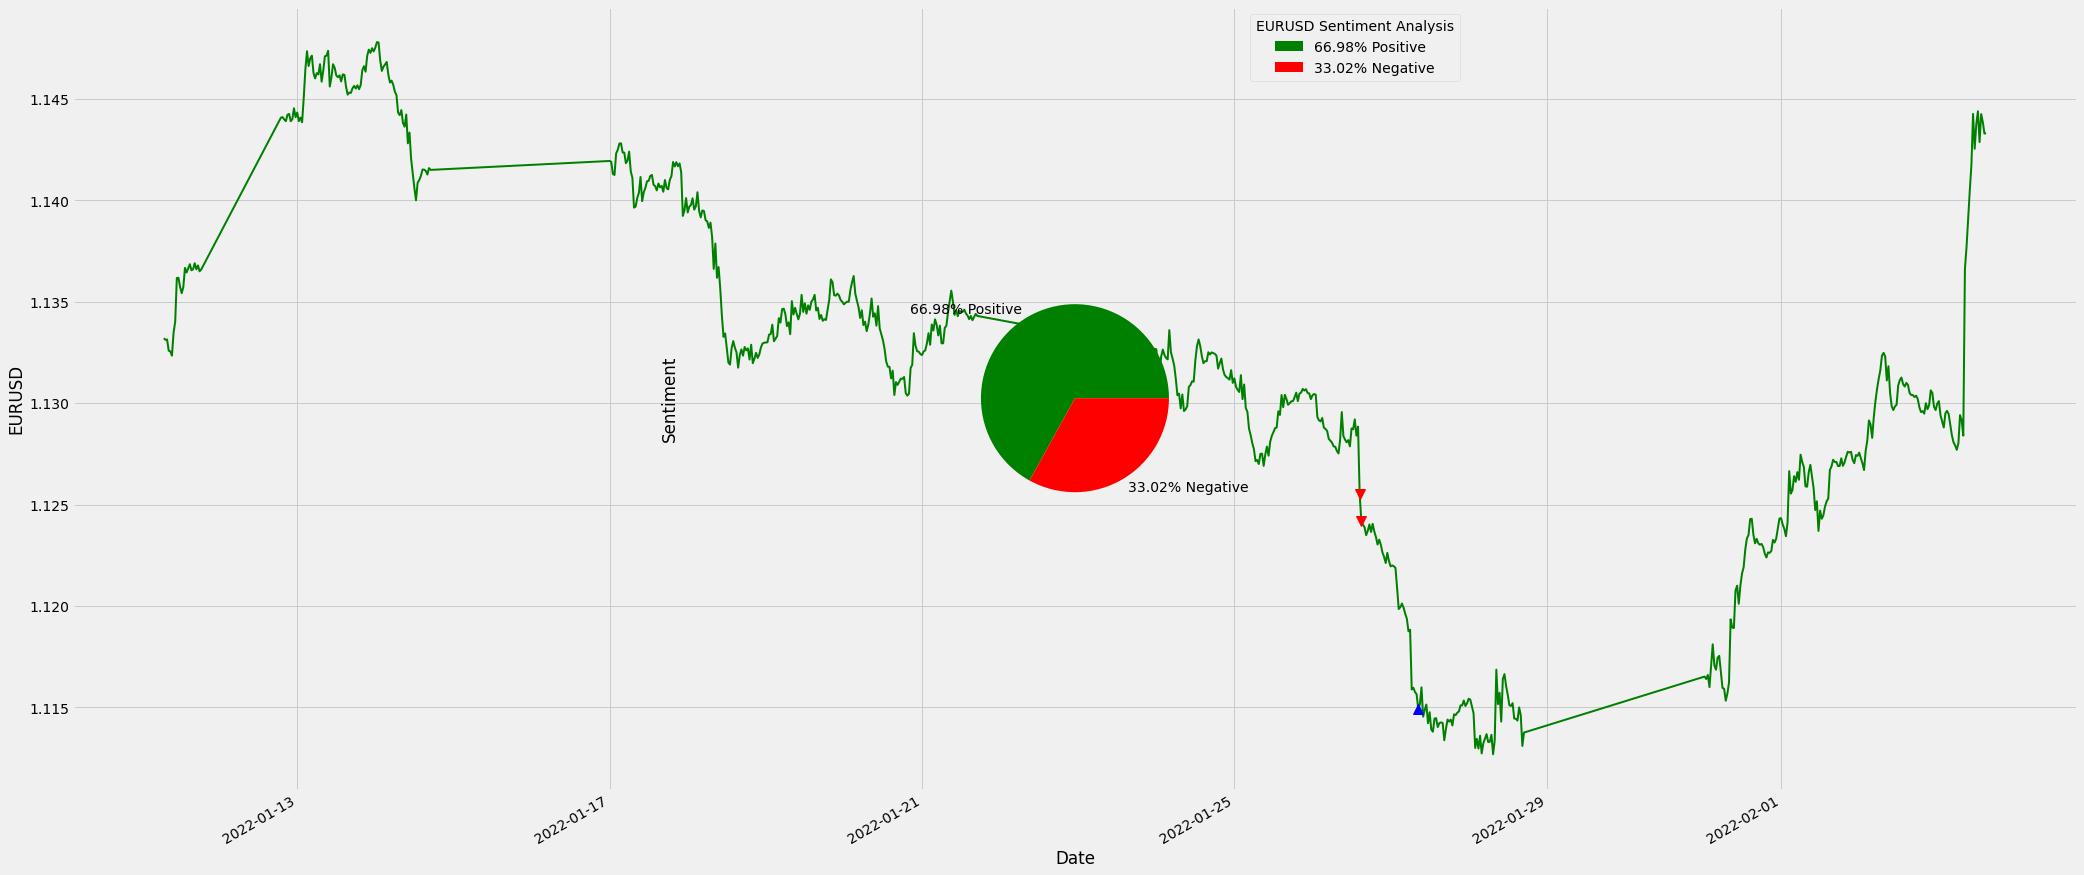

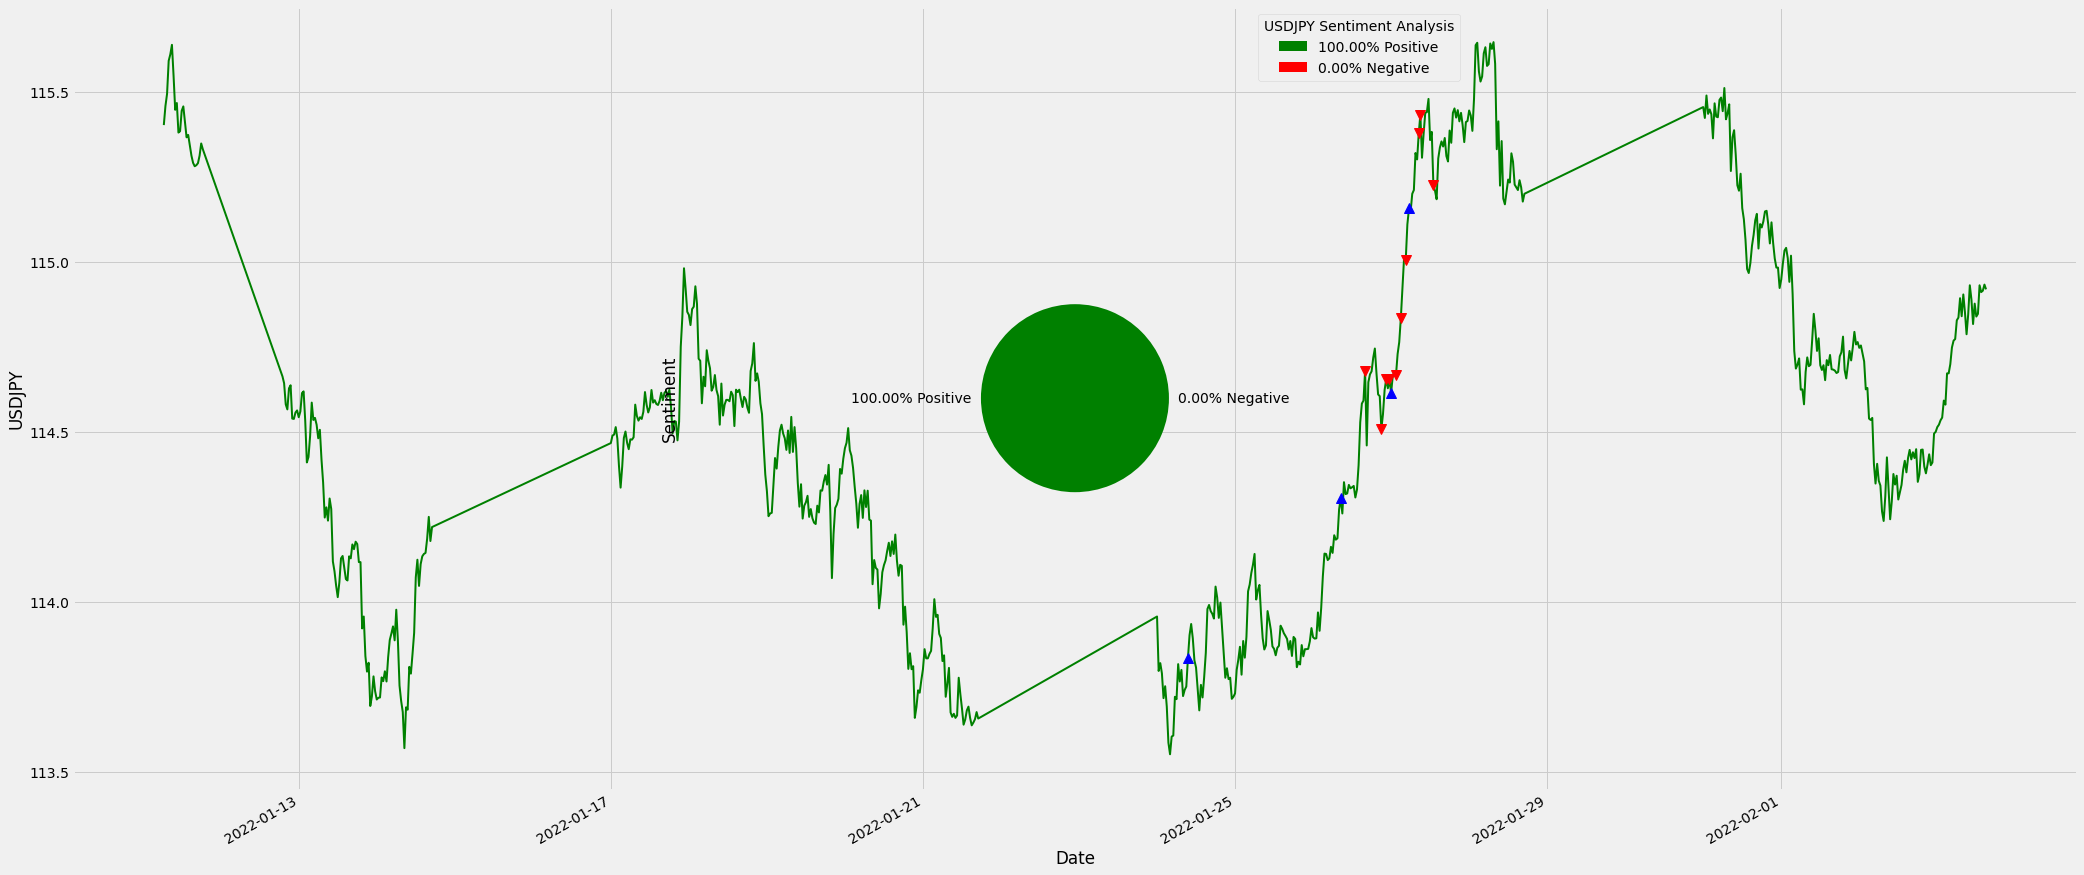

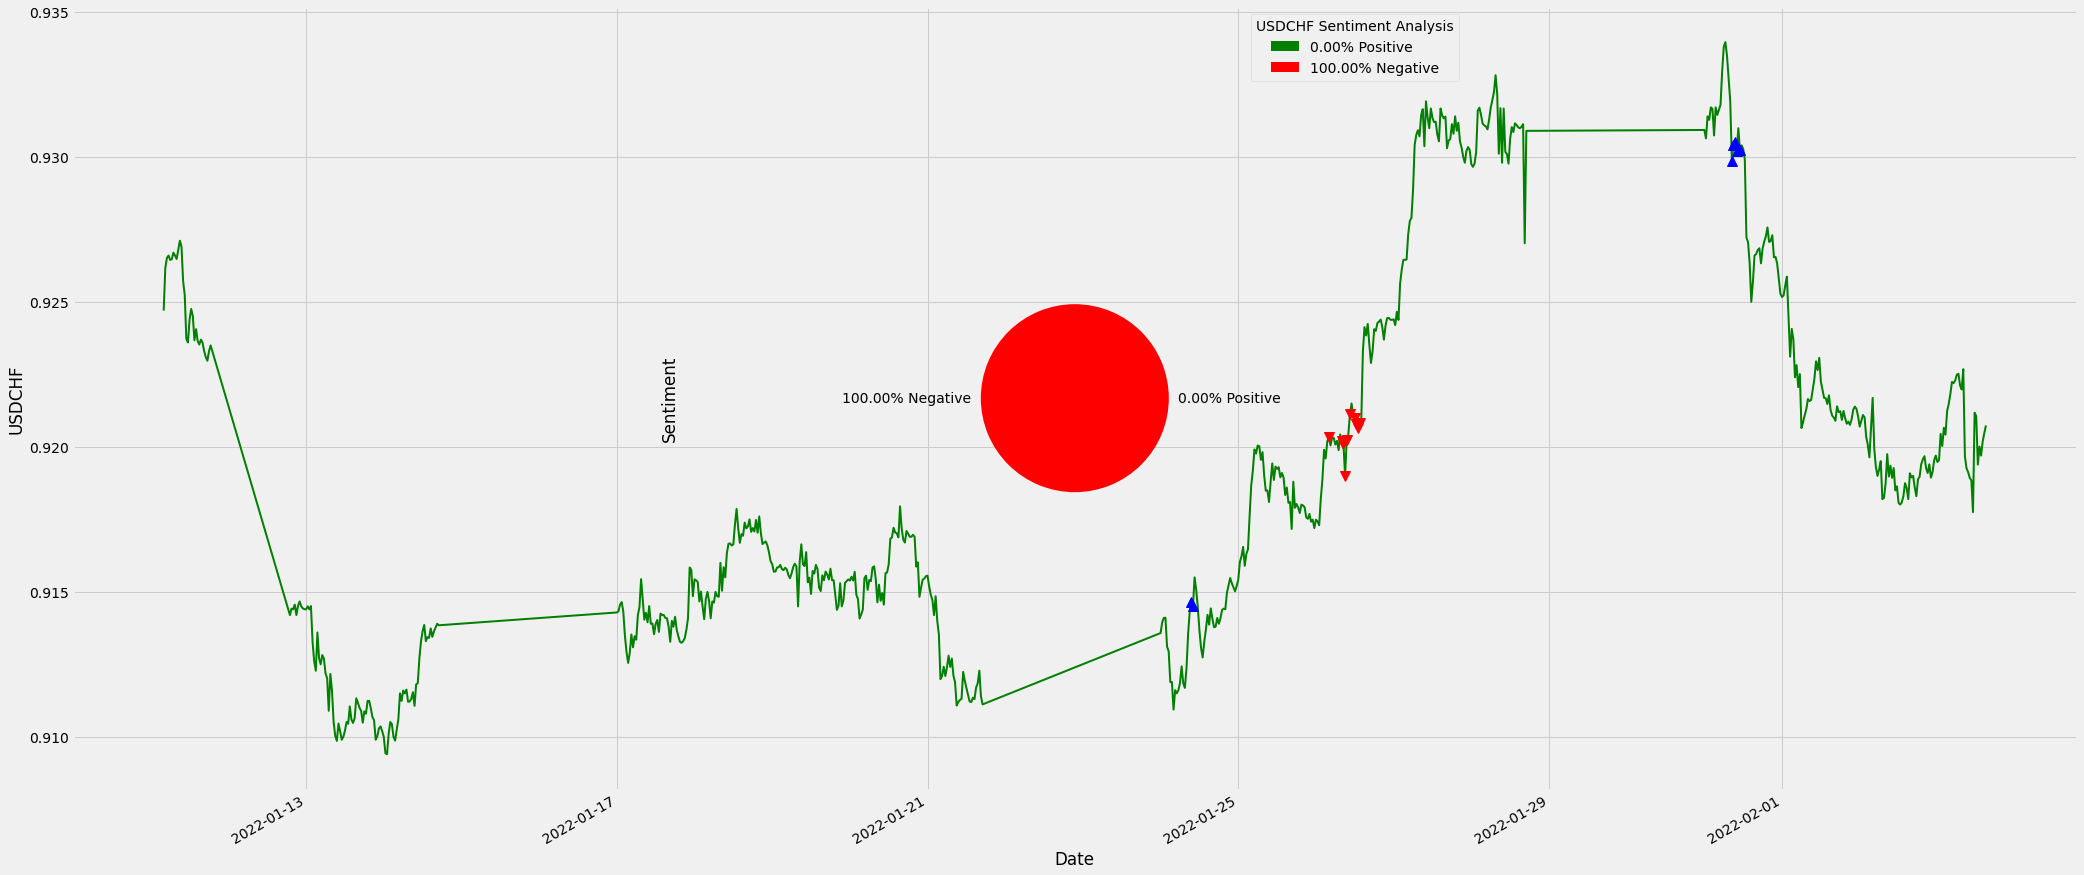

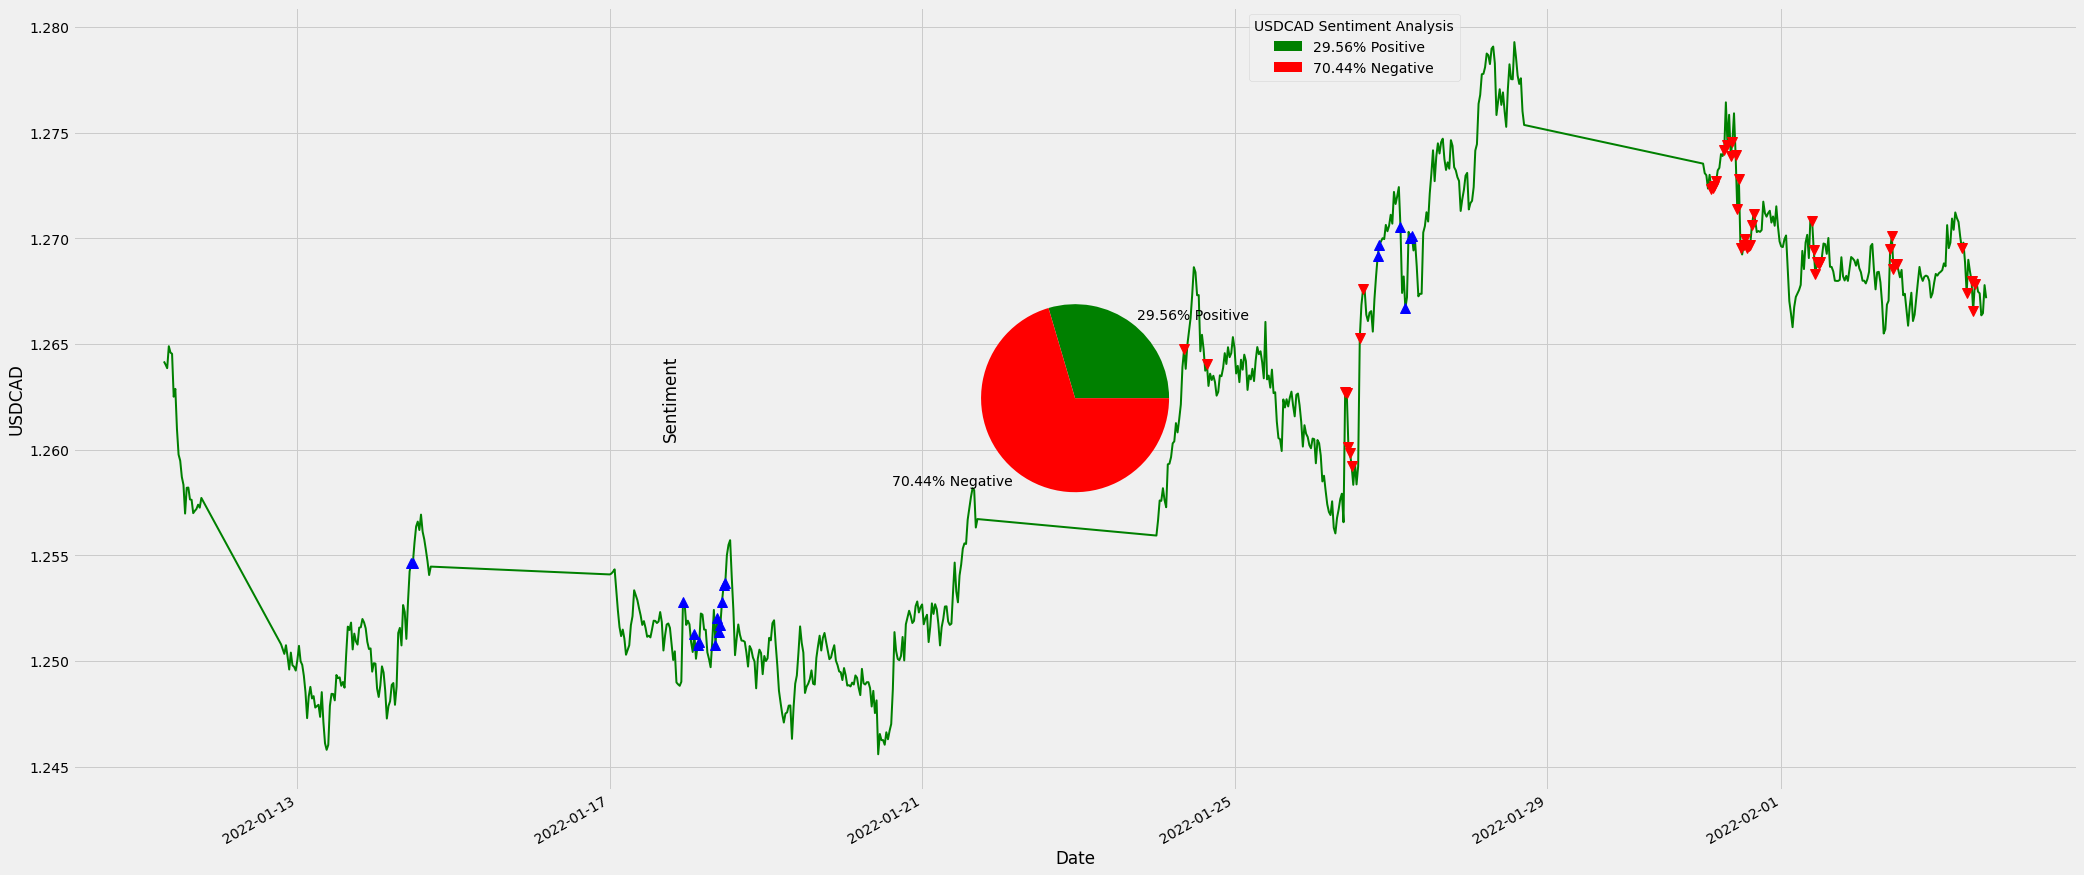

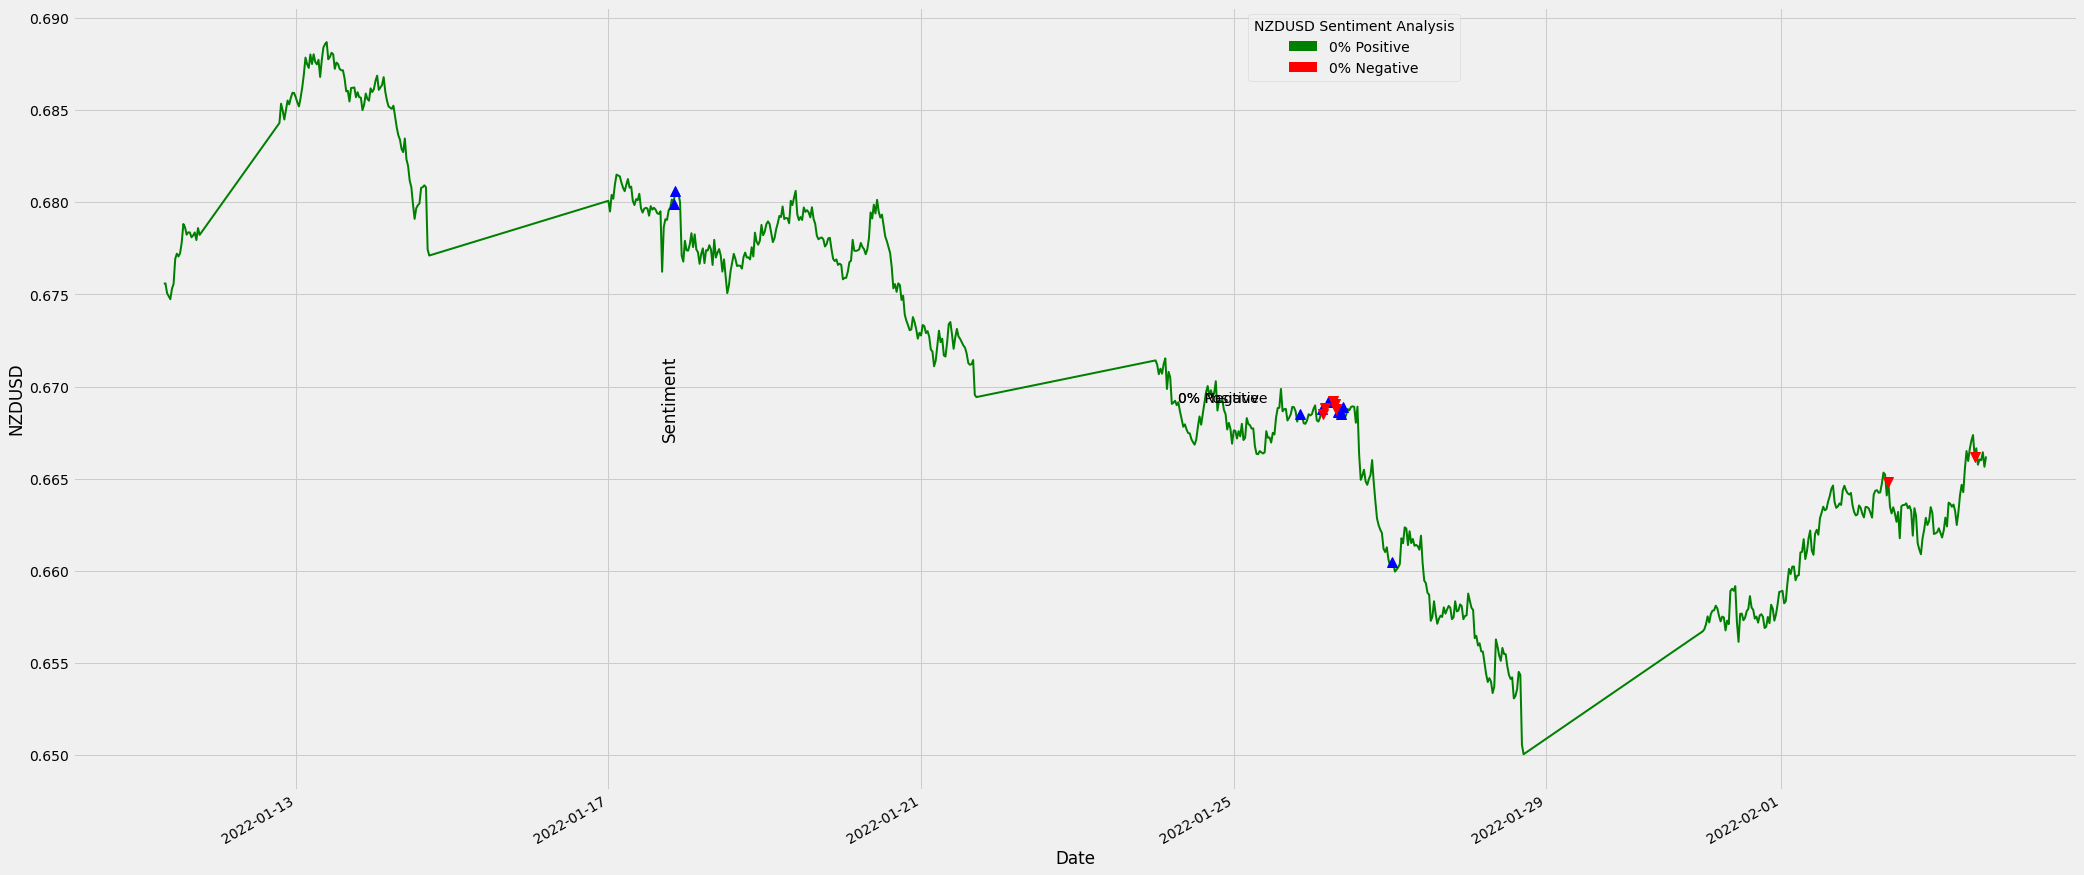

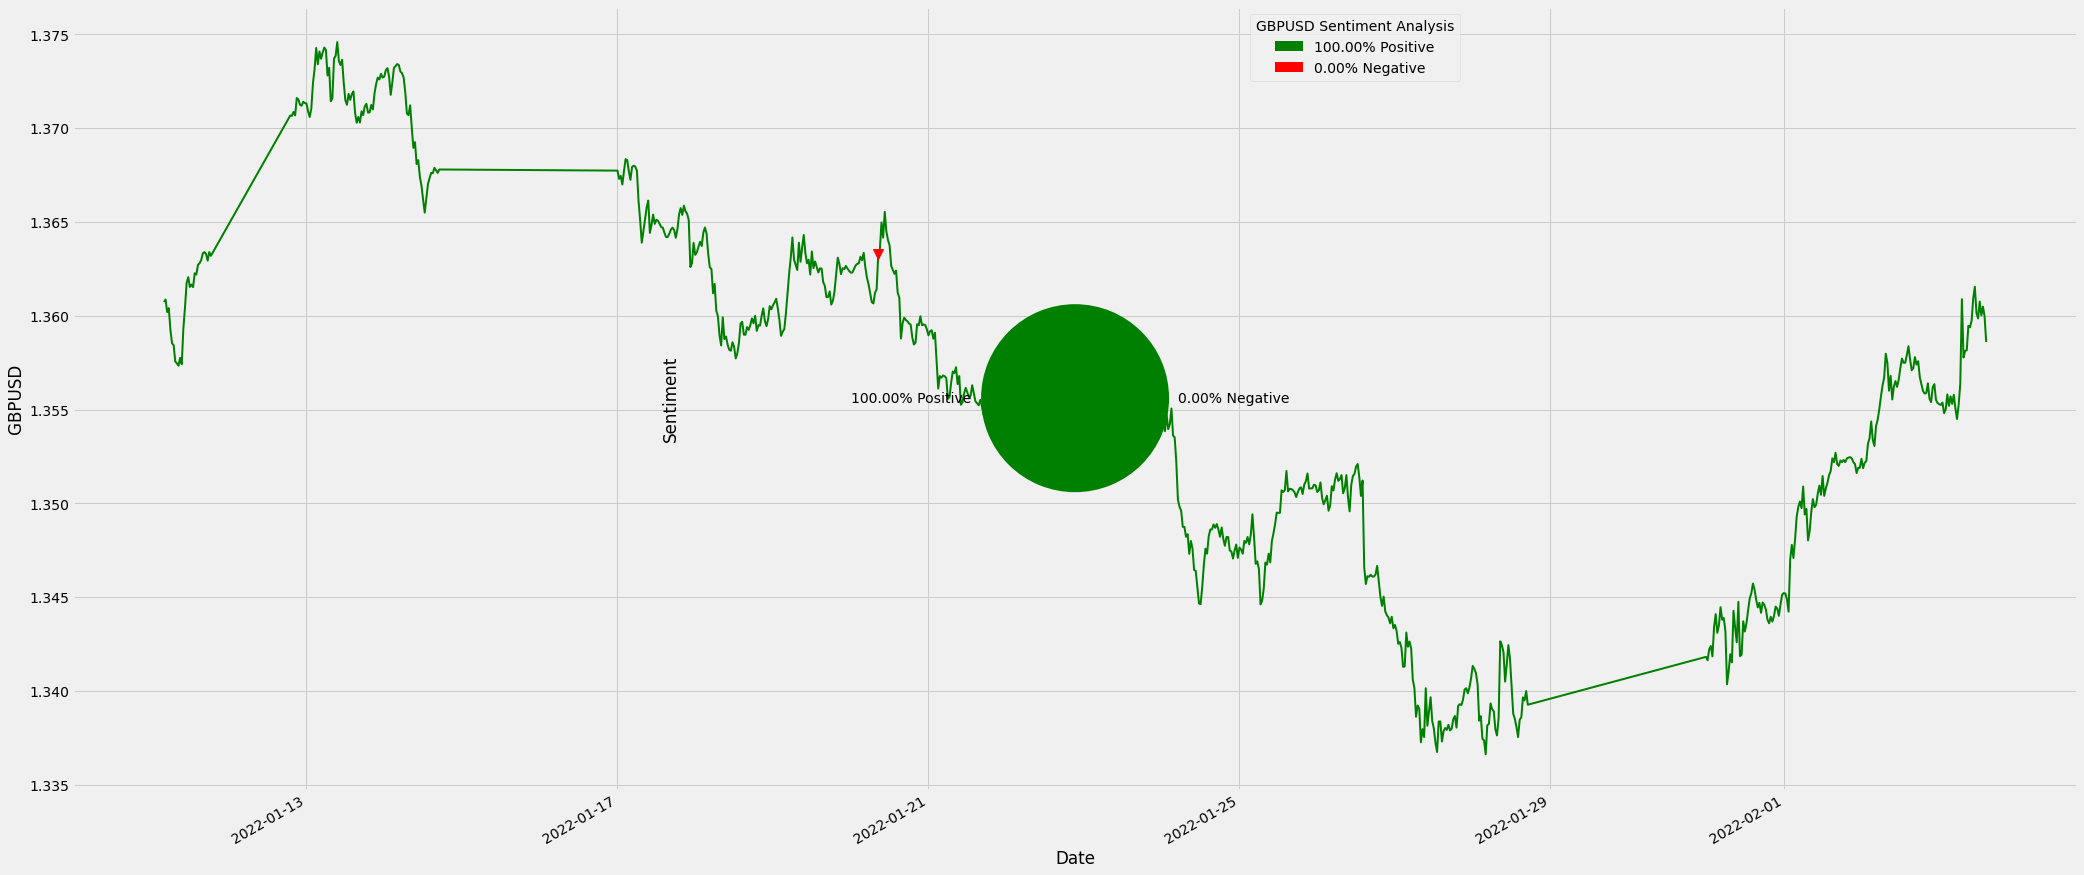

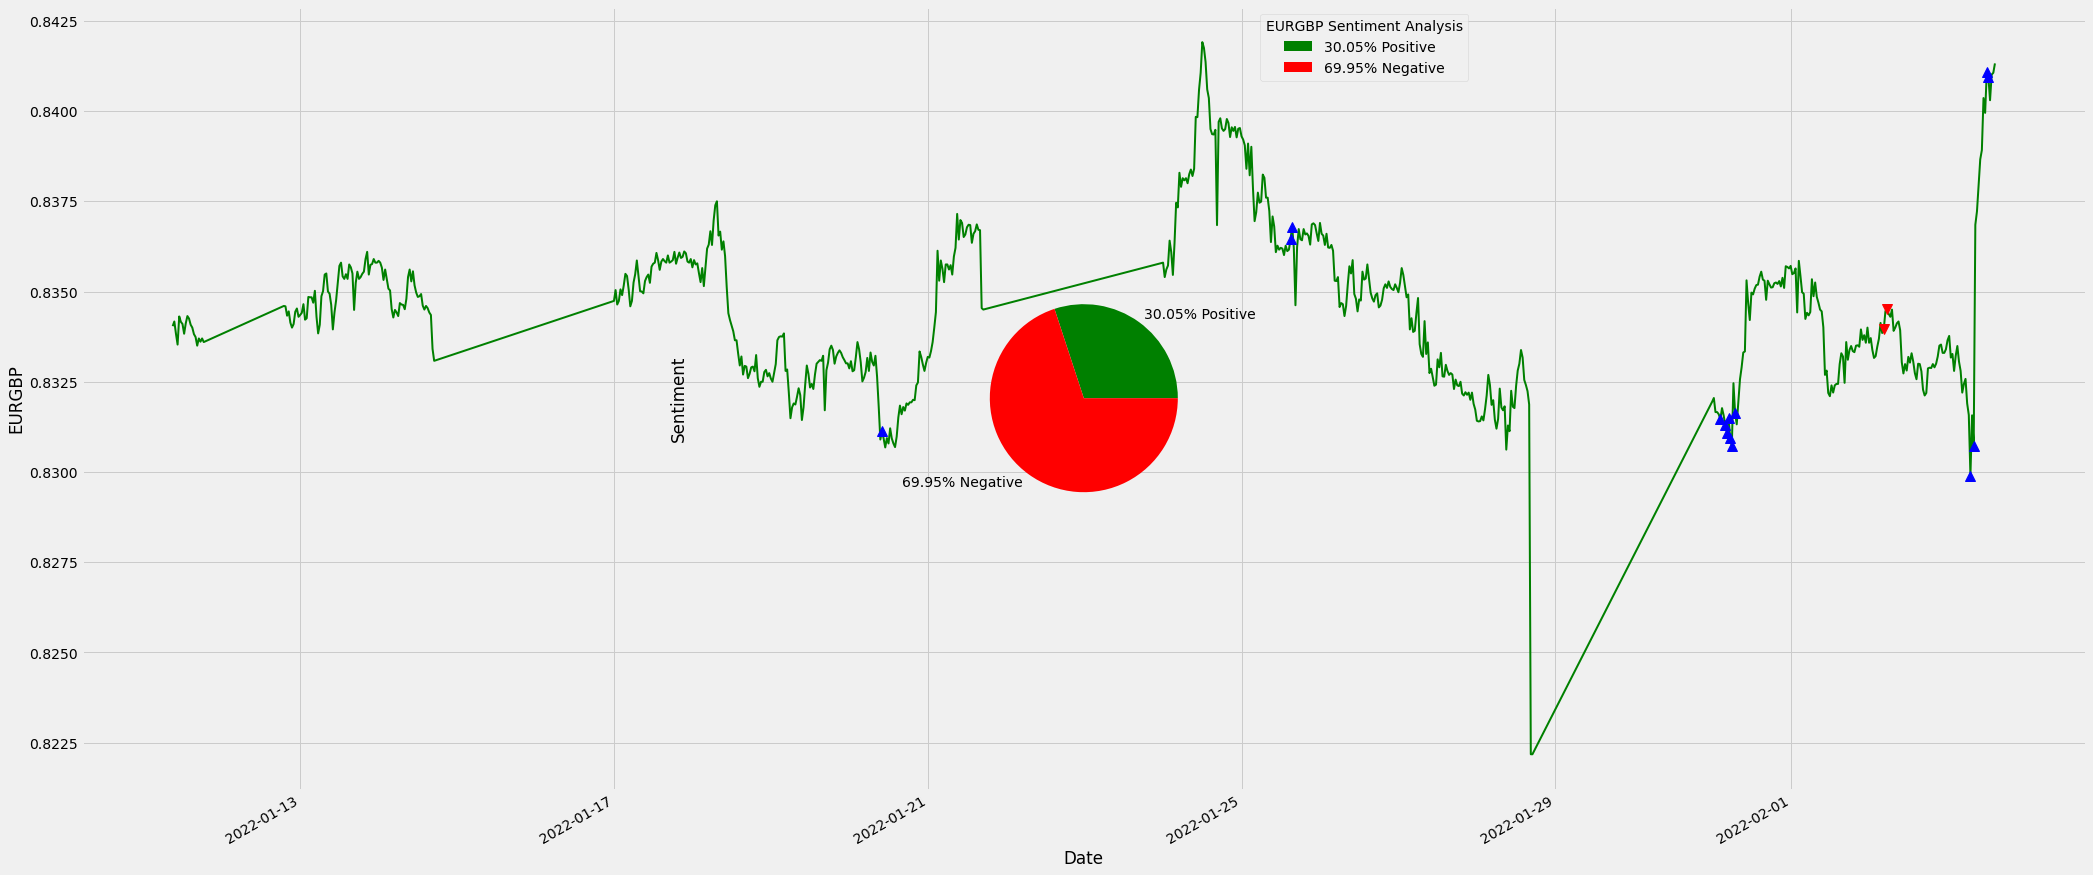

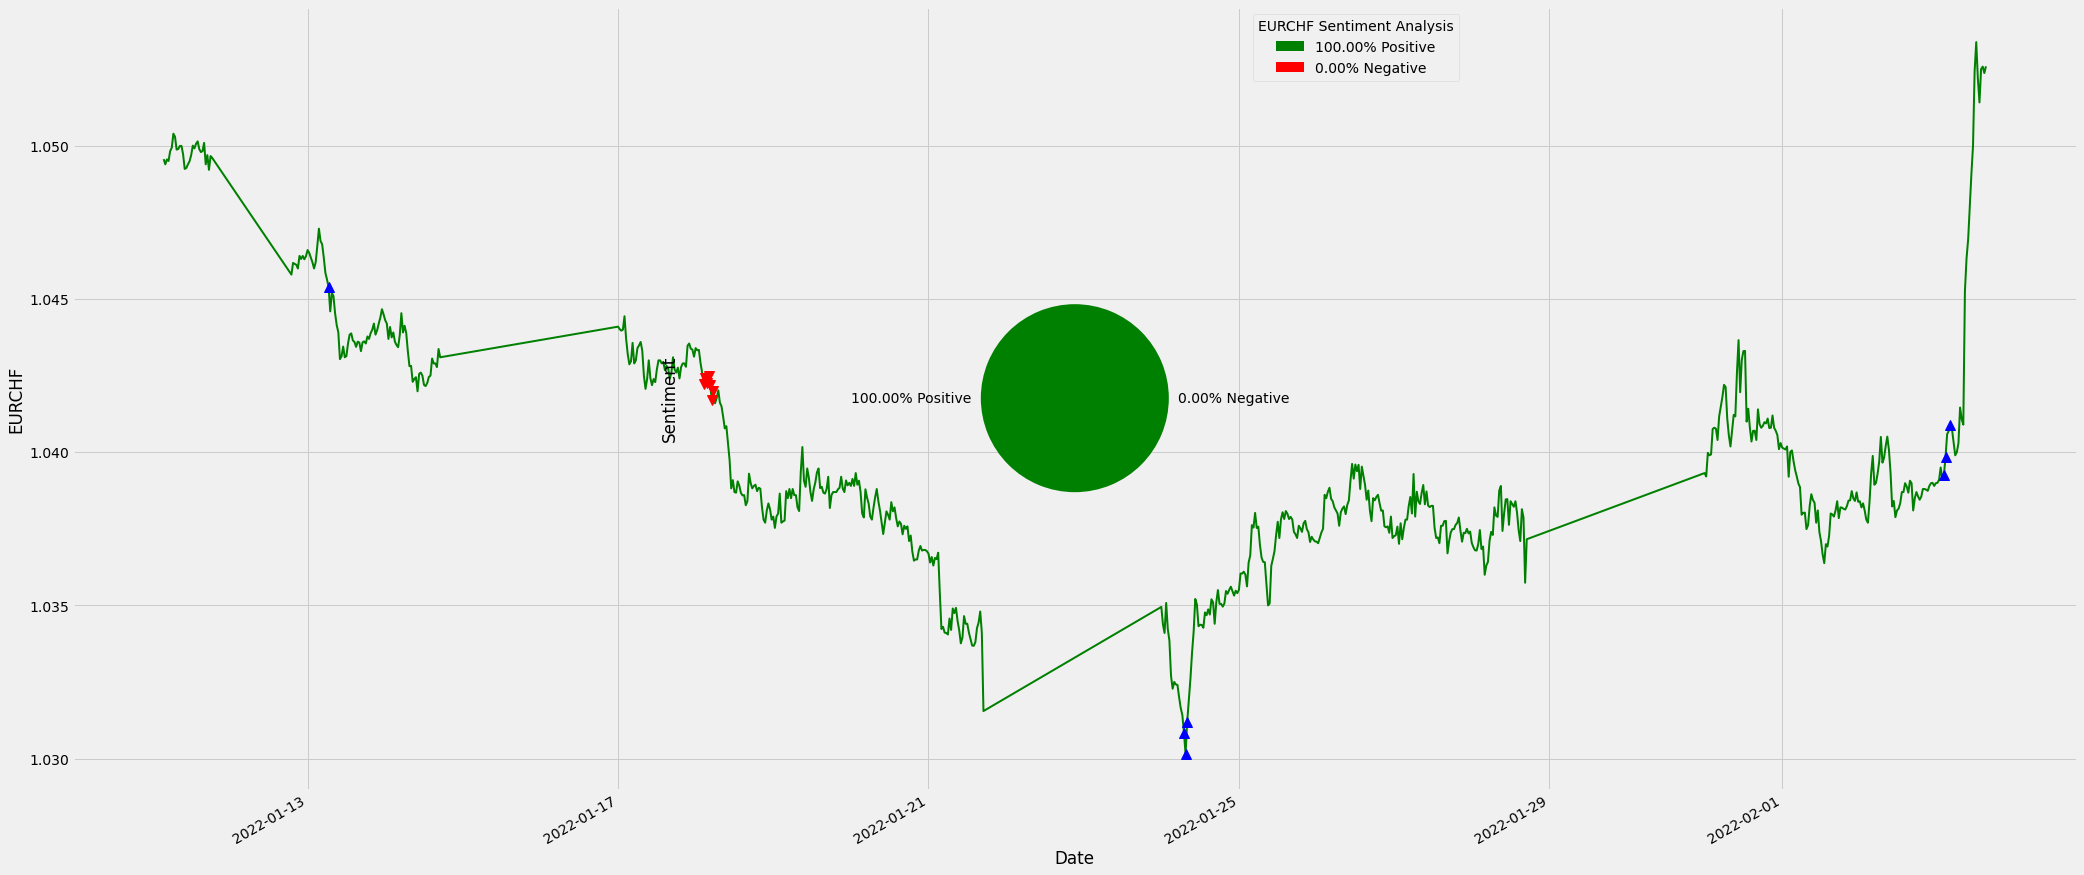

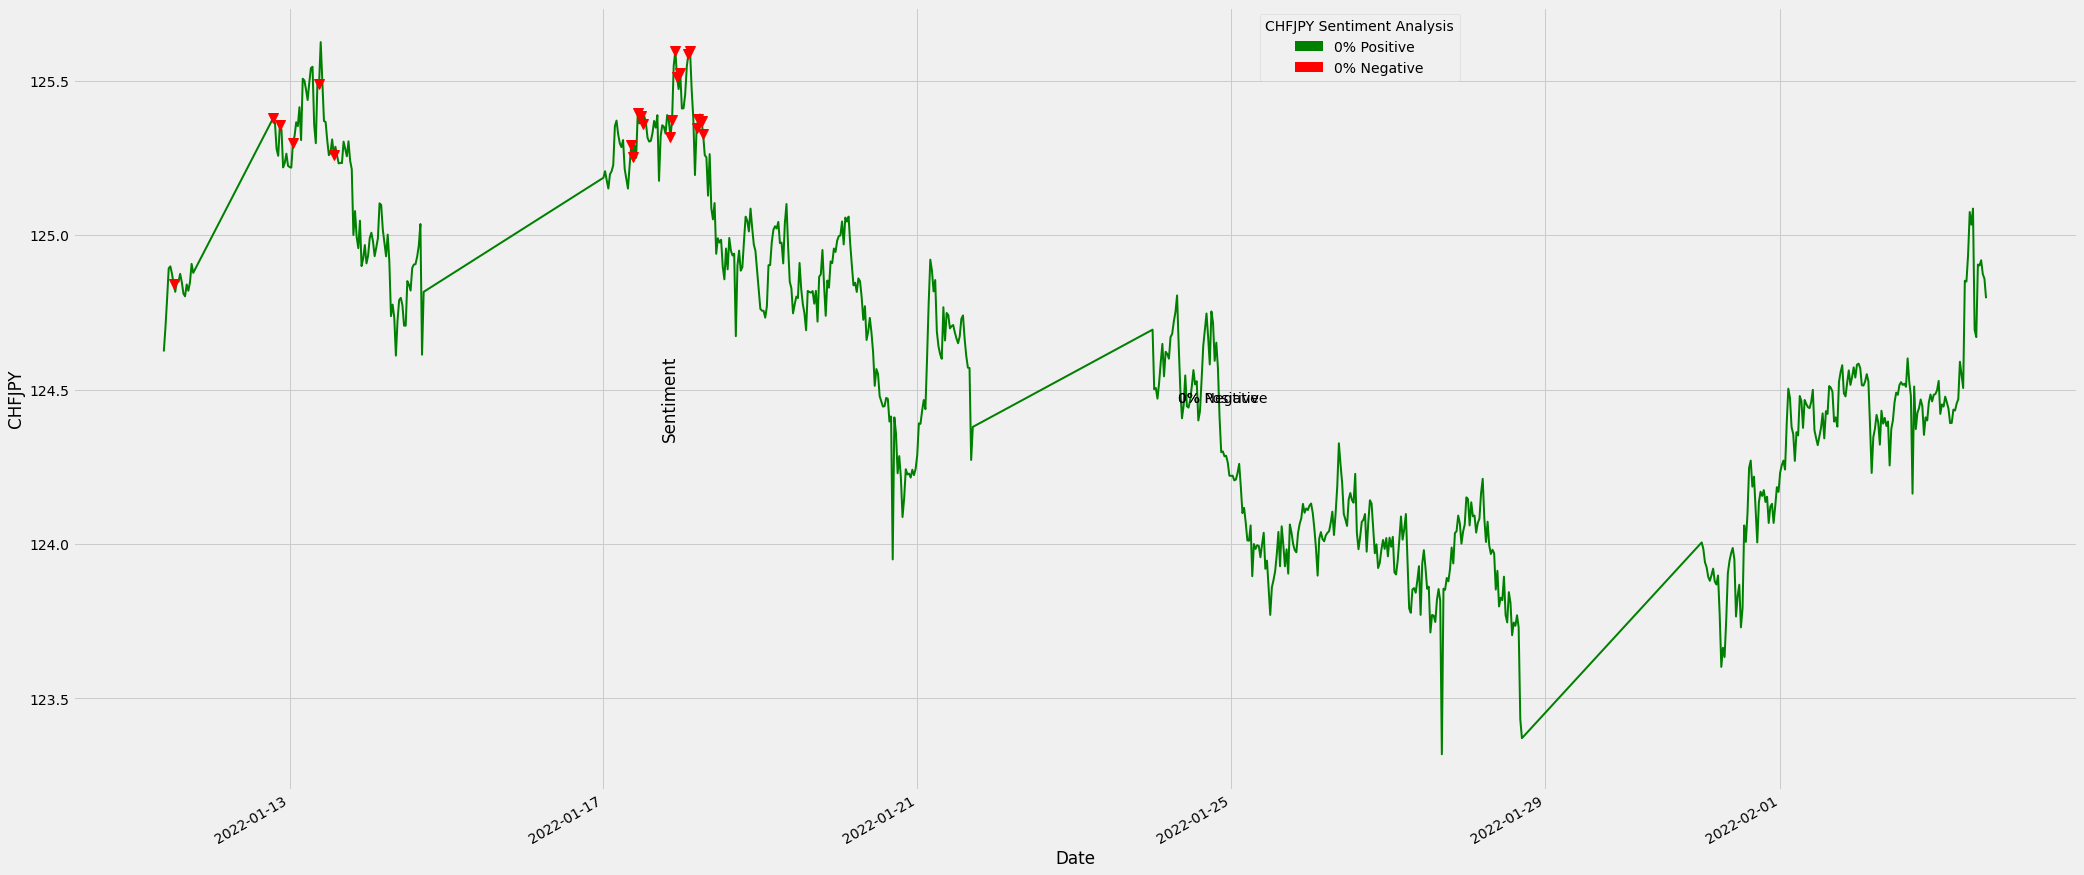

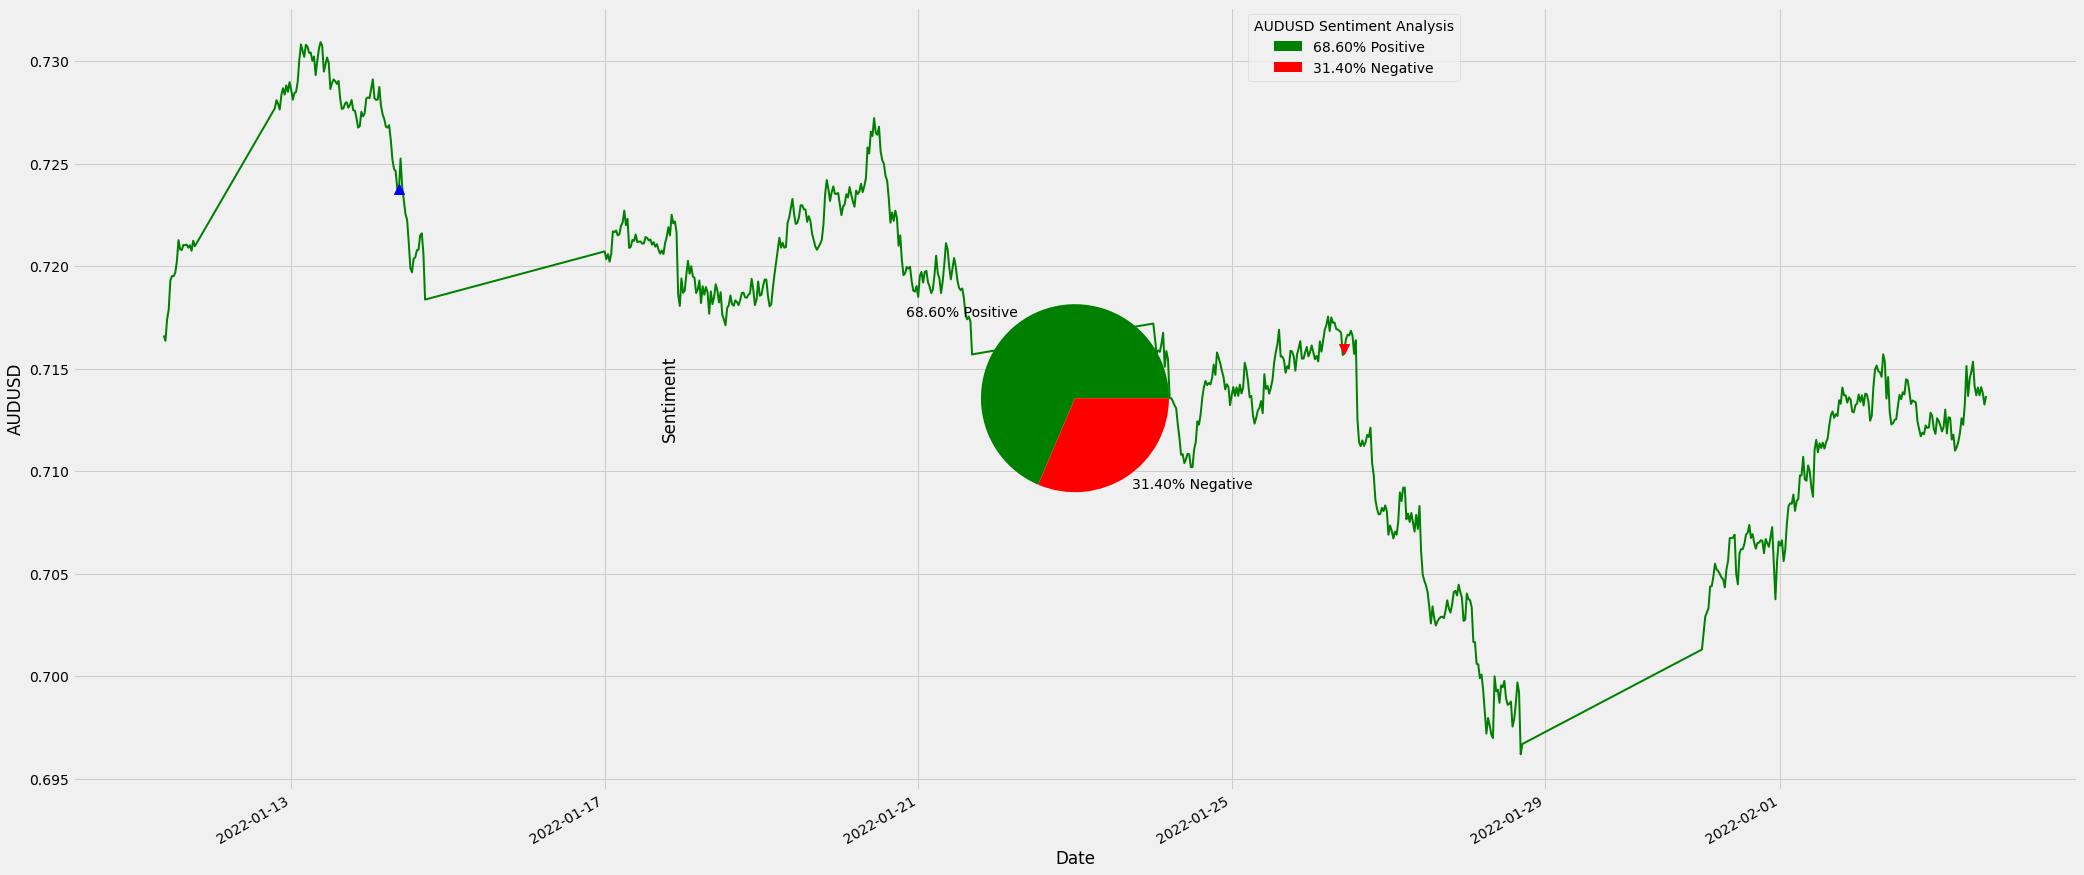

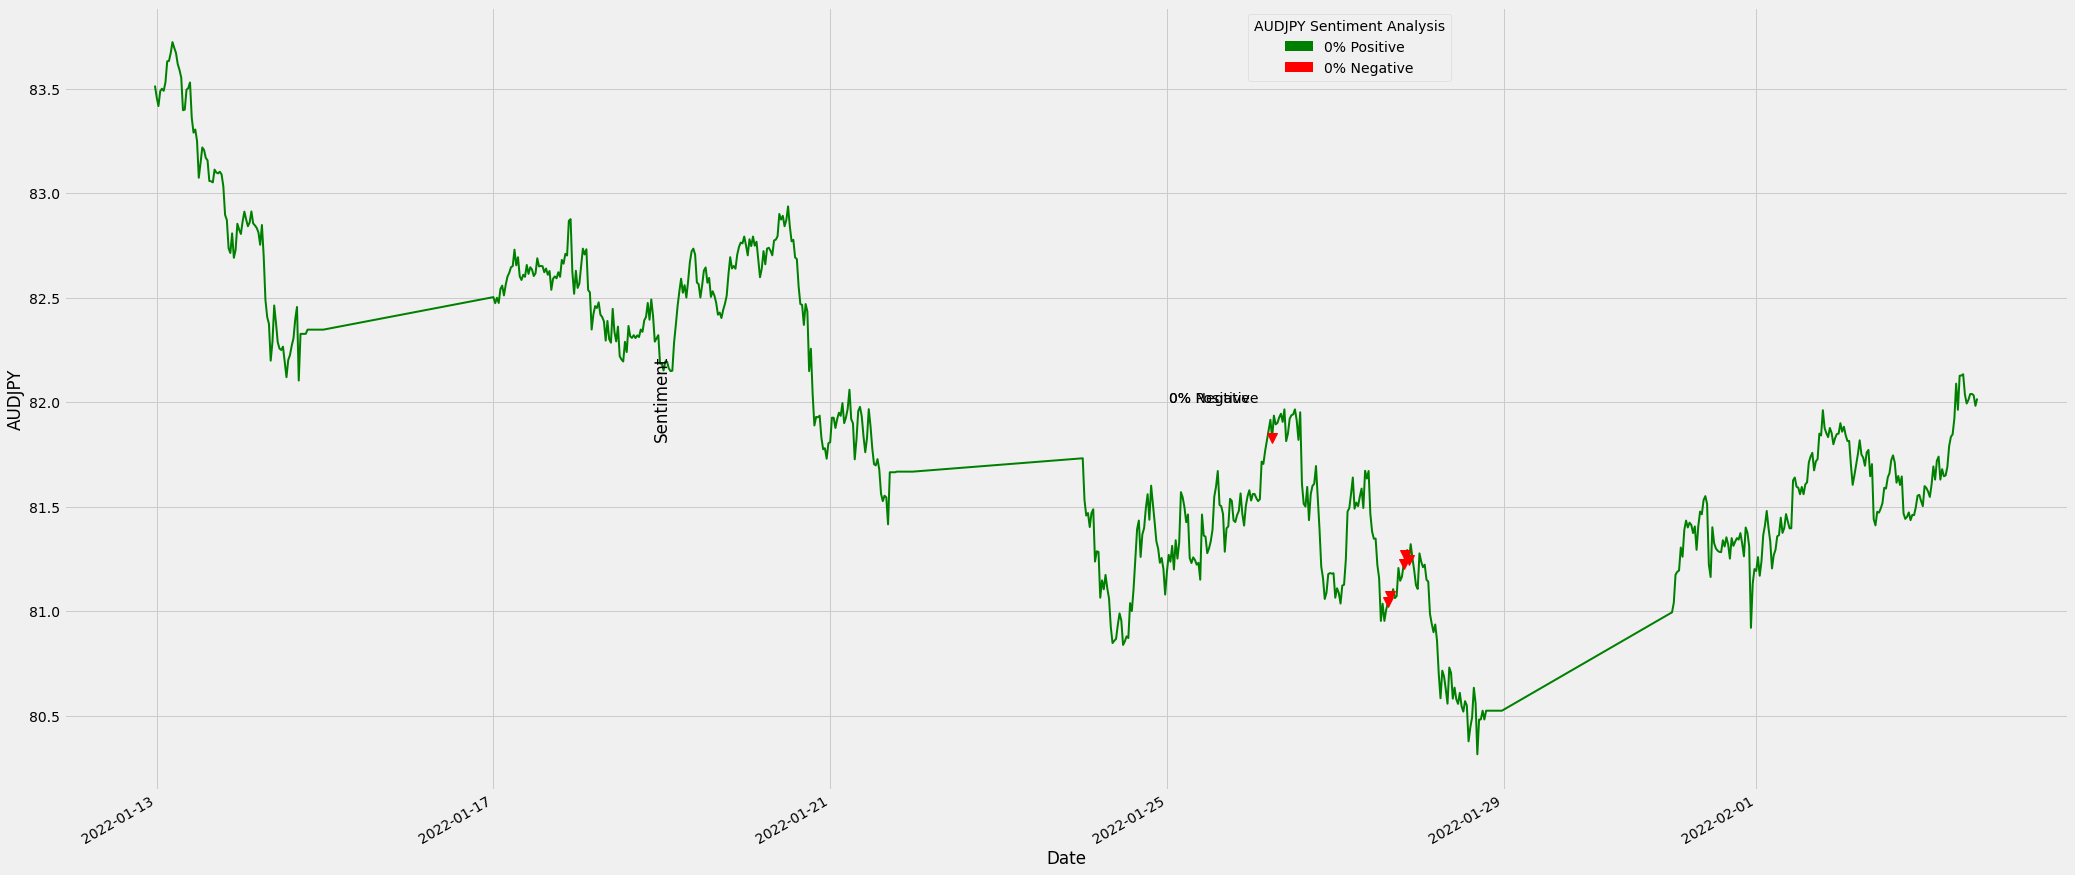

In [11]:
# download the max latest 30mn EURUSD dataframe
# financialmodelingprep time is GMT-5 new york time
import datetime 
import json, urllib.request
target = {}
api_key = 'd1e61f961d0be9c709b1bd6adaa2cca7'
api_endpoint = 'https://financialmodelingprep.com/api/v3/historical-chart/30min/{symbol}?apikey={key}'
for symbol in symbols:
  predict(symbol)